## Using scripts to perform Intel Advisor roofline profiling on Devito

This notebook uses the prewritten scripts `run_advisor.py`, `roofline.py` and `advisor_to_json.py` to show how you can easily profile a Devito application using Intel Advisor 2020 and plot memory-bound/compute-bound roofline models depicting the current state of the application's performance. These scripts can be found in the `benchmarks/user/advisor` folder of the full Devito repository. They are also available as part of the Devito package.

First, we are going to need a couple of imports to allow us to work with Devito and to run command line applications from inside this jupyter notebook. These will be needed for all three scripts.

In [1]:
import devito
from IPython.display import Image
import os

devito_path = os.path.dirname(''.join(devito.__path__))
os.environ['DEVITO_JUPYTER'] = devito_path

### Setting up the Advisor environment

Before running the following pieces of code, we must make sure that the Advisor environment, alongside the Intel C compiler `icc`, are correctly activated on the machine you wish to use the scripts on. To do so, run the following commands:

for Intel oneAPI:

```shell
source /opt/intel/oneapi/advisor/latest/advixe-vars.sh
```

```shell
source /opt/intel/oneapi/compiler/latest/env/vars.sh <architecture, e.g. intel64>
```

or

for Intel Parallel Studio:

```shell
source /opt/intel/advisor/advixe-vars.sh
```

```shell
source /opt/intel/compilers_and_libraries/linux/bin/compilervars.sh <architecture, e.g. intel64>
```

If your Advisor or icc have not been installed in the `/opt/intel/oneapi/advisor` (equivalently `/opt/intel/advisor`) or `/opt/intel/oneapi/compiler` (or `/opt/intel/compilers_and_libraries`) directory, replace them with your chosen path.

### Collecting performance data with `run_advisor.py`

Before generating graphical models or have data to be exported, we need to collect the performance data of our interested program. The command line that we will use is:
```shell
python3 <path-to-devito>/benchmarks/user/advisor/run_advisor.py --path <path-to-devito>/benchmarks/user/benchmark.py --exec-args "run -P acoustic -d 128 128 128 -so 4 --tn 50 --autotune off" --output <path-to-devito>/examples/performance/profilings --name JupyterProfiling
```

* `--path` specifies the path of the Devito/python executable,
* `--exec-args` specifies the command line arguments that we want to pass to our executable,
* `--output` specifies the directory where we want to permanently save our profiling reports,
* `--name` specifies the name of the single profiling that will be effected.

Let's run the command to do the profiling of our example application.

In [2]:
#NBVAL_SKIP

! python3 $DEVITO_JUPYTER/benchmarks/user/advisor/run_advisor.py --path $DEVITO_JUPYTER/benchmarks/user/benchmark.py --exec-args "run -P acoustic -d 128 128 128 -so 4 --tn 50 --autotune off" --output $DEVITO_JUPYTER/examples/performance/profilings --name JupyterProfiling


Set up multi-threading environment ... Done!
Starting Intel Advisor's `roofline` analysis for `JupyterProfiling`
Performing `cache warm-up` run ... Done!
Performing `survey` analysis ... Done!
Performing `tripcounts` analysis ... Done!
Storing `survey` and `tripcounts` data in `/home/devitouser/devito/examples/performance/profilings/JupyterProfiling`
To plot a roofline type: 
python3 roofline.py --name JupyterProfiling --project /home/devitouser/devito/examples/performance/profilings/JupyterProfiling --scale 1.000000


The above call might take a few minutes depending on what machine you are running the code on, please have patience. After it is done, we have Intel Advisor data from which we can generate rooflines and export data.

### Generating a roofline model to display profiling data

Now that we have collected the data inside a profiling directory, we can use the `roofline.py` script to produce a pdf of the roofline data that has been collected in the previous run. There are two visualisation modes for the generated roofline:
* overview: displays a single point with the overall GFLOPS/s and arithmetic intensity of the program
* top-loops: displays all points within runtime within one order of magnitude compared to the top time consuming loop

First, we will produce an 'overview' roofline. The command line that we will use is:
```shell
python3 <path-to-devito>/benchmarks/user/advisor/roofline.py --mode overview --name <path-to-devito>/examples/performance/resources/OverviewRoof --project <path-to-devito>/examples/performance/profilings/JupyterProfiling
```

* `--mode` specifies the mode as described (either `overview` or `top-loops`)
* `--name` specifies the name of the pdf file that will contain the roofline representation of the data
* `--project` specifies the directory where the profiling data is stored

Let's run the command.

In [3]:
#NBVAL_SKIP

! python3 $DEVITO_JUPYTER/benchmarks/user/advisor/roofline.py --mode overview --name $DEVITO_JUPYTER/examples/performance/resources/OverviewRoof --project $DEVITO_JUPYTER/examples/performance/profilings/JupyterProfiling


Opening project...
Loading data...
Figure saved as /home/devitouser/devito/examples/performance/resources/OverviewRoof.png.


Once this command has completed, we can now observe the gathered profiling data through a roofline model.

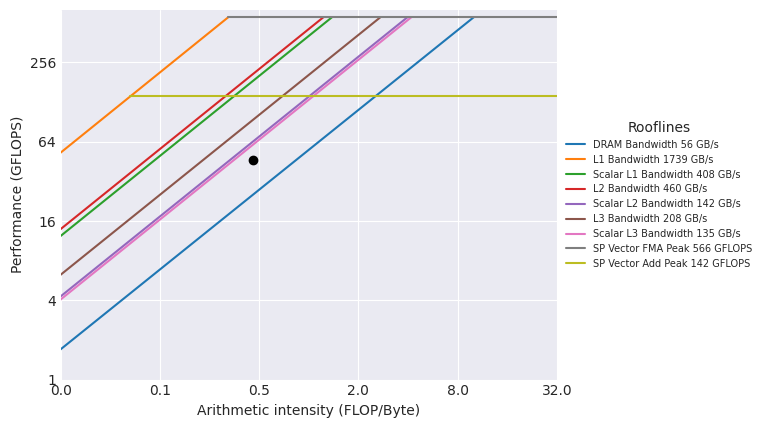

In [4]:
Image(filename=os.path.join(devito_path, 'examples/performance/resources/OverviewRoof.png'))

Similarly, we can also produce a graph which displays the most time consuming loop alongside all other loops which have execution time within one order of magnitude from it. This is done by using `top-loops` mode.

In [5]:
#NBVAL_SKIP

! python3 $DEVITO_JUPYTER/benchmarks/user/advisor/roofline.py --mode top-loops --name $DEVITO_JUPYTER/examples/performance/resources/TopLoopsRoof --project $DEVITO_JUPYTER/examples/performance/profilings/JupyterProfiling


Opening project...
Loading data...
Figure saved as /home/devitouser/devito/examples/performance/resources/TopLoopsRoof.png.


With the command having run, we can inspect the image that has been created and compare it to the overview mode roofline.

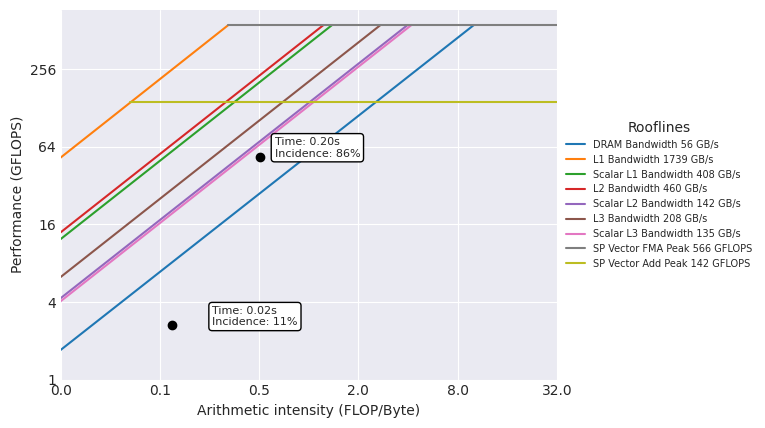

In [6]:
Image(filename=os.path.join(devito_path, 'examples/performance/resources/TopLoopsRoof.png'))

As you can see from this roofline graph, the main point is different from the single point of the previous graph. Moreover, each point is labelled with 'Time' and 'Incidence' indicators. These represent the total execution time of each loop's main body and their percentage incidence on the total execution time of the main time loop.

### Exporting Advisor roofline data as JSON

For easy and flexible exporting, the `advisor_to_json.py` script allows you to pack all the information represented within the previously seen graphs inside a JSON file. The command line which is needed to export our project's data in JSON format is:
```shell
python3 <path-to-devito>/benchmarks/user/advisor/advisor_to_json.py --name <path-to-devito>/examples/performance/resources/RoofsData --project <path-to-devito>/examples/performance/profilings/JupyterProfiling
```

* `--name` specifies the name of the JSON file which will be generated
* `--project` specifies the Advisor folder which contains all the collected data about the application

As always, let's run the command through bash.

In [7]:
#NBVAL_SKIP

! python3 $DEVITO_JUPYTER/benchmarks/user/advisor/advisor_to_json.py --name $DEVITO_JUPYTER/examples/performance/resources/RoofsData --project $DEVITO_JUPYTER/examples/performance/profilings/JupyterProfiling


Opening project...
Loading data...
Figure saved as /home/devitouser/devito/examples/performance/resources/RoofsData.json.


We can now open the generated JSON file to inspect that we indeed have the data extracted from our roofline models.

In [8]:
json_file = open(os.path.join(devito_path, 'examples/performance/resources/RoofsData.json'), 'r')
json_file.read()

'{"roofs": {"memory": [[[0, 10.044770377496254], [0, 565.556228747]], [[0, 0.3251398653506436], [0, 565.556228747]], [[0, 1.385194513137451], [0, 565.556228747]], [[0, 1.2288691632912316], [0, 565.556228747]], [[0, 3.9765711623042126], [0, 565.556228747]], [[0, 2.725070312805007], [0, 565.556228747]], [[0, 4.198971247983363], [0, 565.556228747]]], "compute": [[[0.3251398653506436, 32], [565.556228747, 565.556228747]], [[0.0817139523921172, 32], [142.135246015, 142.135246015]]]}, "overview": {"total_ai": 0.46157430900083685, "total_gflops": 46.574790645791346}}'

Let's take a look at the generated JSON. Inside we can see that the file is subdivided into three sections: one to hold the points used to draw the rooflines (`roofs`), one to contain the single overview point (`overview`) and another one that contains information about the top loops as specified earlier in this tutorial (`top-loops`).

By default, `advisor_to_json.py` collects both overview and top-loops data, but the information to collect can be specified using a `--mode` flag analogous to the one used in `roofline.py`.

### Further flags and functionality

The last two scripts contain more flags that you can use to adjust data collection, displaying and exporting.

`roofline.py`:
* `--scale` specifies how much rooflines should be scaled down due to using fewer cores than available
* `--precision` specifies the arithmetic precision of the integral operators
* `--th` specifies the threshold percentage over which to display loops in top-loops mode

`advisor_to_json.py`:
* `--scale`, as previously
* `--precision`, as previously
* `--th`, as previously

If you want to learn more about what they do, add a `--help` flag to the script that you are executing.